In [ ]:
import os 
import matplotlib.pyplot as plot
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import PatchCollection
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage.feature as si

In [2]:
def get_data(file_name):
    with open(file_name, 'r') as array3D:
        content = array3D.read()
    
    # Sort data into two variables , one with the image data (scan_array)
    # and another with the meta data for the image. 
    scan_array = []
    meta_data = []

    lines = content.splitlines()#[6:]
    for line in lines:
        columns = line.split('\t')
        if len(columns) < 20:
            meta_data.append(columns)
            continue 
        scan_array.append(columns[0:len(columns)-1]) 

    # convert the scan_array list into a float array. 
    image_array = np.array(scan_array, dtype = np.float)
    
    max_fluorescence = np.max(image_array)
    
    return(image_array, meta_data, max_fluorescence)

In [3]:
def xyz_scales(meta_data):
    # Extract the XYZ scaling information from the meta_data list. 
    xyz = meta_data[10]
    XYZscaling = np.array(xyz[0:len(xyz)-1], dtype = np.float)
    #find the maximum scan length
    scan_maxima = [XYZscaling[2]-XYZscaling[1], 
                   XYZscaling[5]- XYZscaling[4],
                   XYZscaling[8]- XYZscaling[7]]
    #find the size of each voxel/pixel
    voxel_size = np.zeros([3])
    for i in range(len(scan_maxima)):
        if scan_maxima[i] == 0:
            continue 
        else:
            voxel_size[i] = scan_maxima[i]/int(XYZscaling[i*3+3]) 

    # Create the pixle arrays for both the x and y range.
    x_scan = np.linspace(0, scan_maxima[0], int(XYZscaling[3]))
    y_scan = np.linspace(0, scan_maxima[1], int(XYZscaling[6]))
    z_scan = np.linspace(0, scan_maxima[2], int(XYZscaling[9]))

    return(x_scan, y_scan, z_scan, voxel_size)

In [4]:
def resize_image_data(image_array, x_d, y_d, z_d):
    
    image_array_3D = image_array.reshape(z_d, y_d, x_d)
    return(image_array_3D)

In [5]:
def get_tick_labels(scan_data, no_of_ticks):
    # Get the values for tick marks incase they are needed for plotting. 
    ticks = [] 
    indicies = []
    
    divider = np.floor(len(scan_data)/no_of_ticks)
    
    for i in range(len(scan_data)):
        if i/divider == np.floor(i/divider):
            ticks.append(scan_data[i])
            indicies.append(i)
    
    return(ticks)

In [6]:
def find_NDs(image_frame, min_dis, num_NDs):
    # Uses the skimage package to locate the local maxima of an image. 
    ND_Locations = []
    for i in range(len(image_frame[:,0,0])):
        ND_Locations.append(si.peak_local_max(image_frame[i, :, :], min_distance = min_dis, 
                                              exclude_border = True, num_peaks = num_NDs))
    ND_Locations = np.array(ND_Locations)
    return(ND_Locations)

In [7]:
def subtract_background(image_array):
    # Find the background fluorescence value.
    background = np.mean(image_array)
    image_array_zero = image_array - background
    return(image_array_zero, background)

In [42]:
def ROI_comparison(image_array, image_array_2, ND_locs):
    # Here we compare the different intensities of the 
    # NDs from two different ND maps. 
    fluor_drop = []
    for i in range(len(ND_locs)):
        y, x = ND_locs[i]
        fluor_drop.append(image_array_2[x,y]/image_array[x,y])

    return(fluor_drop)

In [9]:
def find_useful_NDs(ROI_contrast, limit):
    # identify NDs with a contrast above a limit
    ODMR_NDs = []
    for i in range(len(ROI_contrast)):
        if (1-ROI_contrast[i]) > limit:
            ODMR_NDs.append(i)
    return(ODMR_NDs)

In [10]:
def plot_roi(nd_locs, ax, color, radius):
    ## I have grabbed/ammended this function from: 
    # https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
    # I am sure that this isn't an issue for copyright/IP or anything, but better to be safe. 

    # This function plots all of the regions of interest onto the heatmap. 
    patches = []
    a = 1
    for nd in nd_locs:
        y, x = nd
        c = plot.Circle((x, y), radius)
        ax.annotate('ND ' + str(a), xy = [x-2, y + 10], color = color)
        patches.append(c)
        a += 1
        
    ax.add_collection(PatchCollection(patches, facecolors = "None", edgecolors = color, alpha = 0.5, linewidths = 3))
    return(ax)

In [11]:
def plot_heatmap(image_frame, divider, yticks, xticks, max_fluorescence):
    ## This section produces a seaborn heatmap with no x and y labels or tick marks.

    #generate a subpolt.
    fig, ax = plot.subplots()
    # change the plot text sizes. 
    sns.set(rc={'figure.figsize':(12,8)}, font_scale = 1.5)
    # generate the heatmap 
    
    #Code for making a cube-helix colour map
    #cmap = sns.cubehelix_palette(start = 0.5, rot = .3, reverse = True, dark=0.3, light=1, as_cmap=True)
    cmap = 'viridis'

    heat_map = sns.heatmap(image_frame, vmin =0 , vmax = 0.90*max_fluorescence,
                           cbar_kws = {'label':'\n Counts (per int time)'},
                           xticklabels = divider, yticklabels = divider, cmap = cmap)
    
    # set the tick marks for the heat map.
    ax.set_yticklabels(yticks, rotation = 0)
    ax.set_xticklabels(xticks, rotation = 0)
    # set the x and y labels. 
    ax.set_ylabel('y ' + r'($\mu$m)')
    ax.set_xlabel('x ' + r'($\mu$m)')

    return(fig, ax)

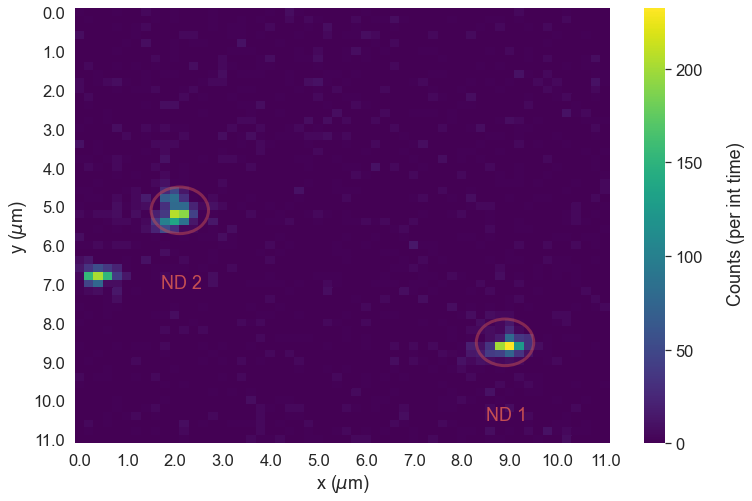

In [47]:
# Get the location of the file of interest in the directory. 
folder_name = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\20200821\\'
date = '20200821'
file_name = folder_name + date + '_04.dat'

# Sort the image data and the meta data into different variables, extract the max fluorescence value. 
image_array, meta_data, max_fluorescence = get_data(file_name)
# Generate arrays describing the 2D scans used to create the image. 
x_scan, y_scan, z_scan, voxel_size = xyz_scales(meta_data)

# Turn the image_array into a 3D array and then store this in a pandas data frame.
image_array_3D = resize_image_data(image_array, len(x_scan), 
                                  len(y_scan), len(z_scan))  

image_array_3D_sb, background = subtract_background(image_array_3D)# subtract the background from the image. 

# Get labels for tick marks.
x_ticks = get_tick_labels(x_scan, 10)
y_ticks = get_tick_labels(y_scan, 10)

tick_divider = int(np.floor(len(x_scan)/10))

fig, ax = plot_heatmap(image_array_3D_sb[1,:,:], tick_divider,
                       y_ticks, x_ticks, max_fluorescence)

radius = int(np.ceil(0.25/voxel_size[0]))+1
NDS = find_NDs(image_array_3D_sb, radius, 2)

plot_roi(NDS[0], ax, 'r', radius = radius)

In [48]:
print(NDS)

[[[43 45]
  [26 11]]

 [[43 45]
  [26 10]]

 [[43 45]
  [26 11]]]


In [49]:
folder_name = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\20200821\\'
date = '20200821'
file_name = folder_name + date + '_07.dat'

# Sort the image data and the meta data into different variables, extract the max fluorescence value. 
image_array_2, meta_data_2, max_fluorescence_2 = get_data(file_name)

# Put the image data into a 3D pandas array.
image_array_3D_2 = resize_image_data(image_array_2, len(x_scan), 
                                  len(y_scan), len(z_scan))  
# Subtract background
image_array_3D_sb_2, background = subtract_background(image_array_3D_2)# subtract the background from the image. 

In [52]:
contrast = ROI_comparison(image_array_3D_sb[1,:,:], image_array_3D_sb_2[1,:,:], NDS[1])
print(contrast)

0.35712994758720407
